In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin

In [2]:
# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)

# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [3]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')

In [4]:
# Define the analytic derivatives for each of the examples in this notebook

# Michaelis–Menten model for enzyme kinetics
def enzyme_deriv(x, t0, jx=0.6, Vmax=1.5, Km=0.3):
    return jx - Vmax * x / (Km + x)


# yeast glycolysis model, note that there are many typos in Kardy's paper for this eq'n
def yeast_deriv(x_y_z_t_u_v_w, t0, c1=2.5, c2=-100, c3=13.6769, d1=200, d2=13.6769,
                d3=-6, d4=-6, e1=6, e2=-64, e3=6, e4=16, f1=64, f2=-13, f3=13, f4=-16,
                f5=-100, g1=1.3, g2=-3.1, h1=-200, h2=13.6769, h3=128, h4=-1.28, h5=-32,
                j1=6, j2=-18, j3=-100):
    x, y, z, t, u, v, w = x_y_z_t_u_v_w
    return [c1 + c2 * x * v / (1 + c3 * v ** 4), 
            d1 * x * v / (1 + d2 * v ** 4) + d3 * y - d4 * y * w,
            e1 * y + e2 * z + e3 * y * w + e4 *z * v, 
            f1 * z + f2 * t + f3 *u + f4 * z * v + f5 * t * w,
            g1 * x + g2 * u, 
            h3 * z + h5 * v + h4 * z * w + h1 * x * v / (1 + h2 * v ** 4), 
            j1 * y + j2 * y * w + j3 * t * w]
    

# Cart on a pendulum
def pendulum_on_cart_deriv(w_x_y_z, t0, m=1, M=1, L1=1, L2=1, F=1, g=9.81):
    w, x, y, z = w_x_y_z
    return [y, z, 
            ((M + m) * g * np.sin(w) - F * np.cos(w) - m * L1 * np.sin(w) * np.cos(
                w) * y ** 2) / (L1 * (M + m * np.sin(w) ** 2)),
            (m * L1 * np.sin(w) * y ** 2 + F - m * g * np.sin(w) * np.cos(
                w)) / (M + m * np.sin(w) ** 2)]


# Infamous double pendulum problem (frictionless if k1=k2=0)
def double_pendulum_deriv(w_x_y_z, t0, m1=0.2704, m2=0.2056, a1=0.191, a2=0.1621, L1=0.2667, L2=0.2667, 
                          I1=0.003, I2=0.0011, g=9.81, k1=0, k2=0):
    return [y, z, (L1 * a2 ** 2 * g * m2 ** 2 * np.sin(w) - 2 * L1 * a2 ** 3 * z **2 * m2 **2 * np.sin(
                w - x) + 2 * I2 * L1 * g * m2 * np.sin(w) + L1 * a2 **2 * g * m2 **2 *np.sin(
                w - 2 * x) + 2 * I2 * a1 * g * m1 * np.sin(w) - (L1 * a2 * y * m2) ** 2 * np.sin(
                2 * (w - x)) - 2 * I2 * L1 * a2 * z ** 2 * m2 * np.sin(
                w - x) + 2 * a1 * a2 ** 2 * g * m1 * m2 * np.sin(w)) / (2 * I1 * I2 + (L1 * a2 * m2
                ) ** 2 + 2 * I2 * L1 ** 2 * m2 + 2 * I2 * a1 ** 2 * m1 + 2 * I1 * a2 ** 2 * m2 - (
                L1 * a2 * m2) ** 2 * np.cos(2 * (w - x)) + 2 * (a1 * a2) ** 2 * m1 * m2), 
                (a2 * m2 * (2 * I1 * g * np.sin(
                x) + 2 * L1 ** 3 * y ** 2 * m2 * np.sin(w - x) + 2* L1 ** 2 * g * m2 * np.sin(x) + 2* I1 * L1 * y **2 * np.sin(
                w - x) + 2* a1 ** 2 * g * m1 * np.sin(x) + L1 ** 2 * a2 * z ** 2 * m2 * np.sin(
                 * (w - x)) + 2 * L1 * a1 ** 2 * y ** 2 * m1 * np.sin(w - x) - 2 * L1 ** 2 * g * m2 * np.cos(
                w - x) * np.sin(w) - 2 * L1 * a1 * g * m1 * np.cos(w - x) * np.sin(w))) / ( 2 * (
                I1 * I2 + (L1 * a2 * m2) ** 2 + I2 * L1 ** 2 * m2 + I2 * a1 ** 2 * m1 + I1 * a2 ** 2 * m2 - (L1 * a2 * m2) ** 2 * np.cos(
                w - x) ** 2 + a1 ** 2 * a2 ** 2 * m1 * m2))]


# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            else:
                eval_string += ' - eval(feature_names[' + str(coef_index + k) + '])' # du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
            temp_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
            temp_string = eval_string
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string, temp_string


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ full_coefficients, axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [5]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0 = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme_deriv, x0, t)
x0 = np.random.rand(r)
x_test = integrate.odeint(enzyme_deriv, x0, t)

# define hyperparameters
threshold = 1e-3

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 is the default values used for cvxpy
# and differs from the normal definition in PySINDy
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(499, 1)


SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7fd534c59490>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, threshold=0.001))

0 1
1 du[0]
2 u[0]
3 u[0]*du[0]
4 u[0]*u[0]
5 u[0]*u[0]*du[0]
6 u[0]*u[0]*u[0]
7 u[0]*u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*u[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
(10, 1) du[0]


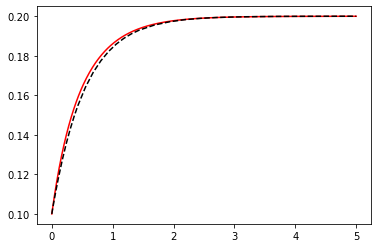

In [6]:
coef_index = 1
coefs = (sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string, temp_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_index)
print(coefs.shape, feature_names[coef_index])

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    resid = eval(eval_string)
    return resid


u0 = [0.1]
du0 = [-0.04]
tspan = (0.0,5.0)
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, u0, tspan, differential_vars=differential_vars)
plt.plot(t, integrate.odeint(enzyme_deriv, u0[0], t), 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

In [ ]:
# define parameters
r = 4
dt = 0.01
T = 50
t = np.arange(0, T + dt, dt)
# control input
F_train = -0.2 + 0.5 * np.sin(6 * t)
F_train[t > 16.0] = 0.0
#F_test = -1 + np.sin(t) + 3 * np.sin(2 * t)
F_test = -0.5 + 0.2 * np.sin(t) + 0.3 * np.sin(2 * t)
F_test[t > 2.0] = 0.0

x0 = [0.3, 0, 1, 0]
x_train = integrate.odeint(pendulum_on_cart_deriv, x0, t)
#x0 = [0.1, 0, 0.1, 0]
x0_test = [np.pi, 0, 0, 0]
x_test = integrate.odeint(pendulum_on_cart_deriv, x0_test, t)

# define hyperparameters
threshold = 1e3

xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))

x_library_functions = [lambda x:1, lambda x:x, lambda x:cos(x), lambda x:sin(x),
                       lambda x: sin(x) * sin(x), lambda x: sin(x) * cos(x)]
xdot_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x:'cos(' + x + ')', lambda x: 'sin(' + x + ')',
                          lambda x: 'sin(' + x + ')' + 'sin(' + x + ')', 
                          lambda x: 'sin(' + x + ')' + 'cos(' + x + ')',
                          lambda x:'', lambda x:x, lambda x: x + x] 
# library_function_names = [lambda x:'', lambda x:x, lambda x:x, lambda x:x,
#                           lambda x, y: x + y, 
#                           lambda x, y: x + y, 
#                           lambda x, y: x + y, 
#                           lambda x:'', lambda x:x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# max_iter = 10000 is the default values used for cvxpy
# and differs from the normal definition in PySINDy
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=2000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t) #, u=F_train)
print(model.get_feature_names())
print(np.shape(model.get_feature_names()))
#model.print()

(4999, 4)


/usr/local/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [44]:
print(sindy_opt.coef_)

[[ 1.74534732e-11 -5.23700281e-07 -1.74507219e-06 ... -1.15216679e-06
   1.04141924e-06 -1.85238541e-06]
 [ 2.34987807e-07  1.99633129e-10 -7.07318432e-07 ...  1.98778402e-07
  -3.29813423e-06  4.72040315e+00]
 [ 7.67471780e-09 -7.25017638e-07  2.95367377e-10 ... -5.77662278e-06
   1.27163121e-06 -5.62214721e-06]
 ...
 [ 1.30234005e-04 -2.62313029e-04 -6.50428805e-06 ...  6.41027409e-09
   1.15850506e+00 -3.73586558e-01]
 [ 2.56796041e-04  2.92809236e-04  2.69504671e-05 ...  4.03210199e-02
   3.97706414e-08  4.72312275e-01]
 [-1.84517392e-04 -2.00550441e-04 -2.10488223e-05 ... -2.86151994e-02
   6.07033656e-01  4.58219104e-08]]


In [45]:
print(np.shape(sindy_opt.Theta), np.shape(sindy_opt.coef_))

(199, 189) (189, 189)


(199, 4)
(201, 4) (199, 189)


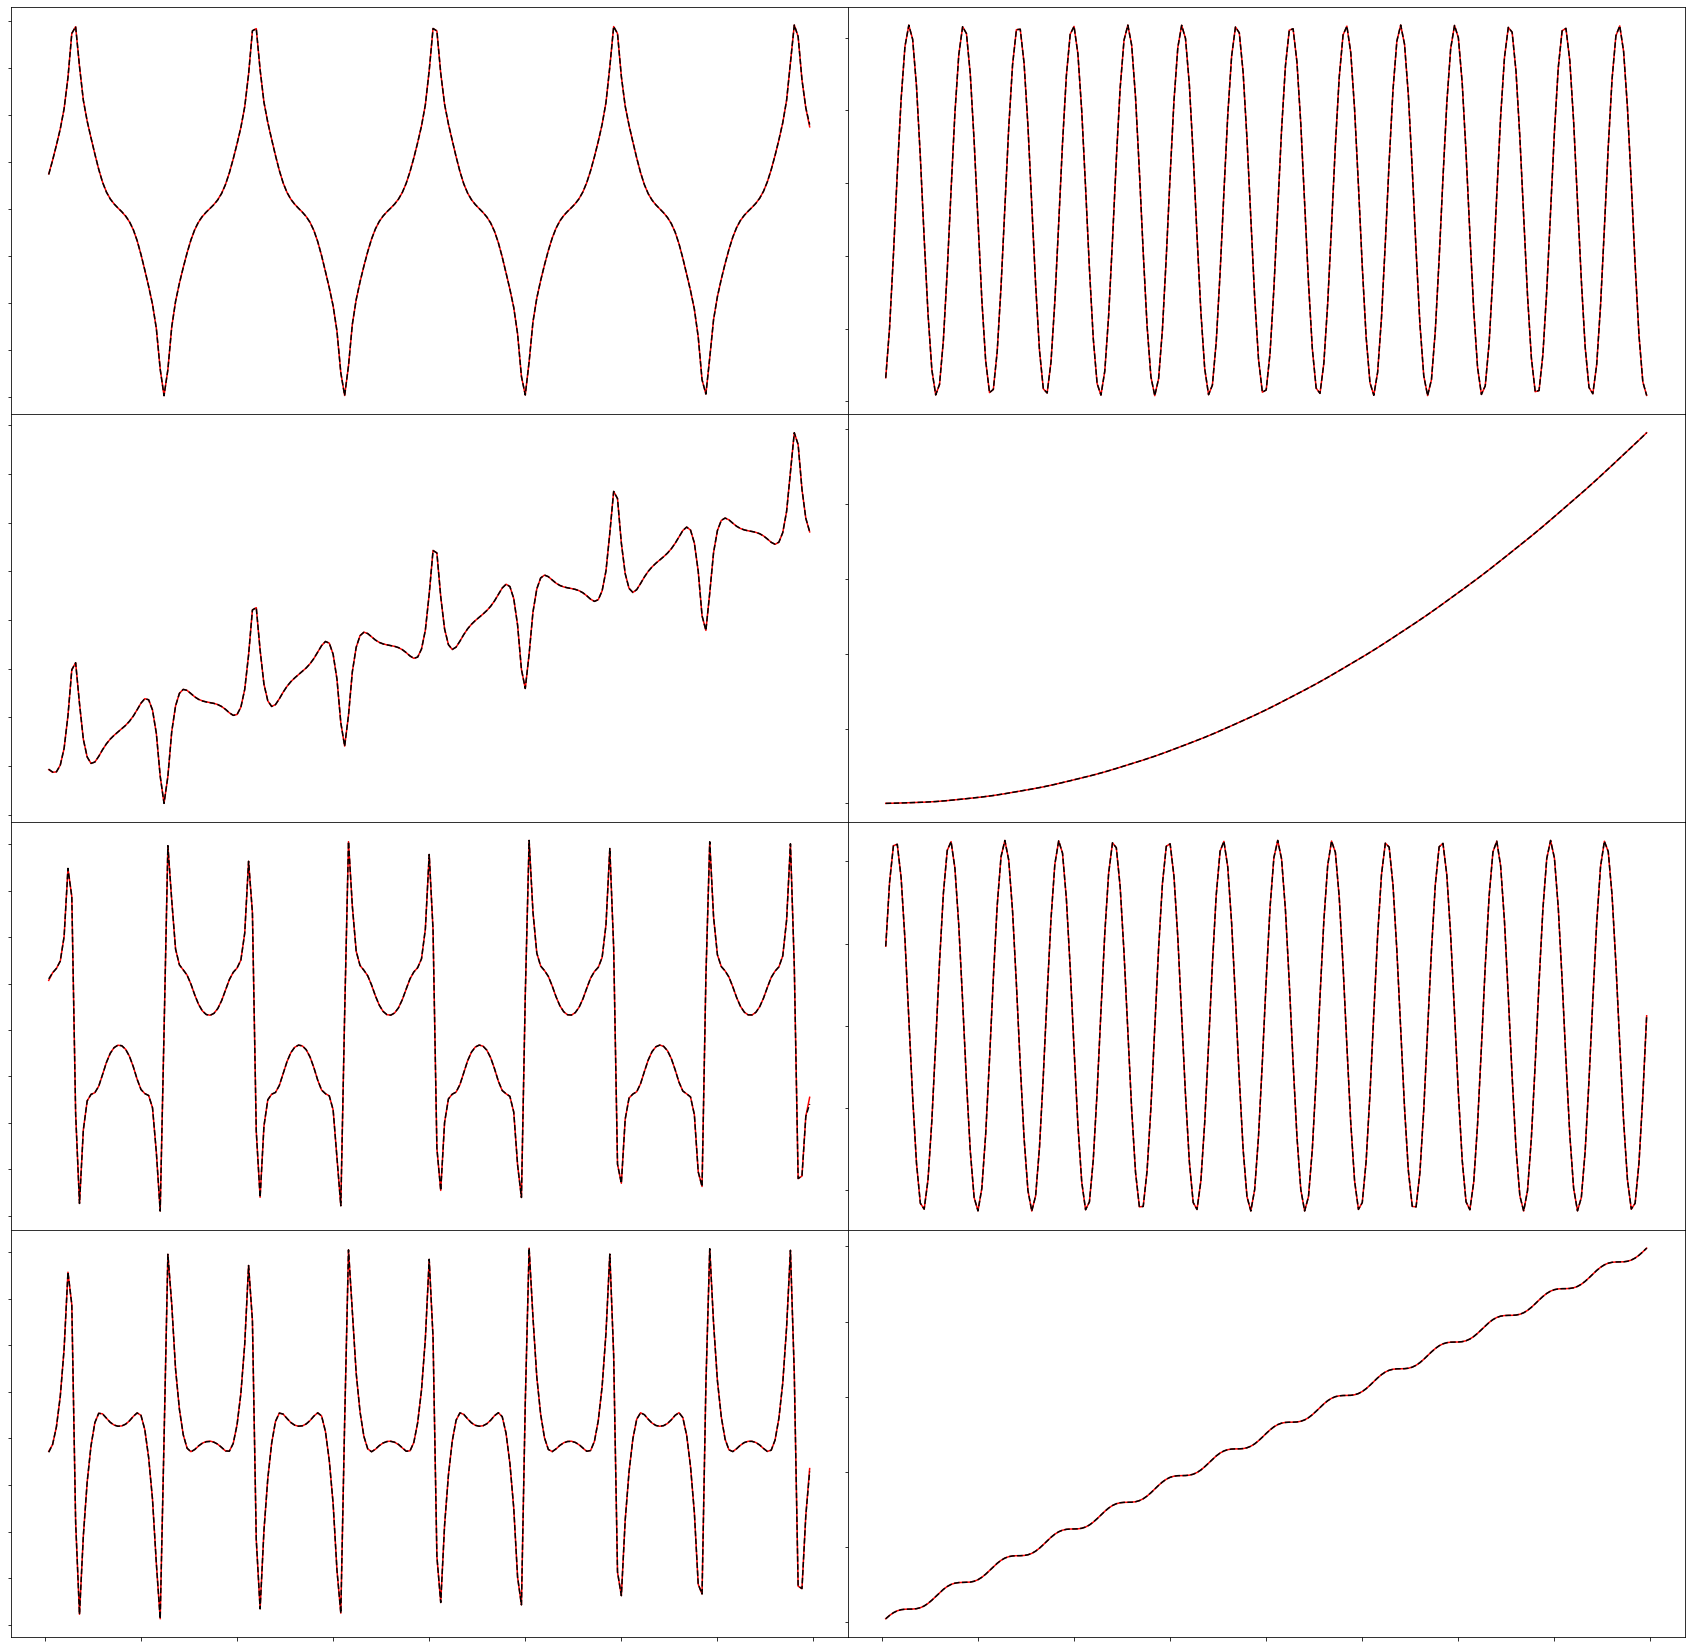

In [46]:
xdot_test = model.differentiate(x_train, t=t)[1:-1, :]
print(xdot_test.shape)
xdot_test_pred = sindy_opt.Theta @ sindy_opt.coef_
print(x_test.shape, xdot_test_pred.shape)
make_fits(r, t[1:-1], xdot_test, xdot_test_pred[:, 1:1+r], x_test[1:-1], x_test[1:-1], 'pendulum_on_cart')

In [11]:
coef_index = 1
r = 4
coefs = (sindy_opt.coef_)[:, coef_index: coef_index + r]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string, temp_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index)
print(eval_string, np.shape(coefs))

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 20)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
#plt.plot(t, integrate.odeint(pendulum_on_cart_deriv, u0, t), 'r')
plt.plot(sol.t, sol.u, 'k--')
print(sol)

0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]
58 cos(u[2])*du[1]
59 cos(u[2])*du[2]
60 cos(u[2])*du[3]
61 cos(u[3])*du[0]
62 cos(u[3])*du[1]
63 cos(u[3])*du

[-0.003165758625643278, 0.004322120348717373, 0.101201673744157, -0.004486462161454763]
[0.0023580543420648192, 0.002353832067847339, -0.02496896977936558, 0.00027873786702015124]
[-0.0010603536050146634, -0.0013017682276317277, 0.005641456499155595, 7.336993962303584e-05]
[0.0003156268508558435, 0.00041693289205357864, -0.0012579405618105, -4.0922288280009766e-05]
[-8.426117427506874e-05, -0.00011494630341934986, 0.0002734390257934649, 1.34886495718467e-05]
[2.0901802343042952e-05, 2.9099849813141176e-05, -5.83248343595244e-05, -3.7478370721322207e-06]
[-0.6744469618224571, 0.002196854965813788, -4.604846065348056e-06, 0.00017790803763317875]
[0.1070740856093867, -5.873551132791132, 0.19809596775576743, -0.4384432715977774]
[5.774489582673372, 10.578918924710896, 37.08011035407393, -3.272604119482005]
[-8.568529021259568, -6.804965885490087, -1.9166614063765426, 22.028858730135784]
[-2.738928942536134e-07, -9.744271947997873e-06, -3.579202258841008e-05, 4.296520880076038e-06]
[-2.9439

[0.13950938915814604, -0.08166548047115896, -0.0658452622080663, 0.08480612020663436]
[0.5338499684006353, 0.15454749957589797, 0.139504782259813, 0.3550715243869682]
[0.05391901430380219, -0.04016228835649338, -0.07632801771937459, 0.0005694400102829178]
[0.011092407972191687, -0.0001769851867146066, -0.0027598719427803786, -2.6162747778002426e-05]
[0.3024772944441043, -0.027499480008064126, -0.11066214245828121, -0.028578898925690766]
[1.1961845069742019, 0.1218749298924191, -0.04554453241217438, 0.030059911921805238]
[0.3024772944441043, -0.027499480008064126, -0.11066214245828121, -0.028578898925690766]
[0.33056339594082296, -0.011477521295179205, -0.11444622948362415, -0.025060697408521904]
[0.3041418441701804, -0.10741076610746081, -0.10810782653210005, -0.028488501781794184]
[0.8505312089576496, 0.20574250861328558, 0.13144330871399568, 0.333087908652999]
[0.1567213099363407, -0.08131591109485115, -0.12800218639904415, -0.12489129006153732]
[0.17921450045638743, 0.02188865674586

[-1.6191122078200904, -0.5909979662486058, -0.216110485595852, -1.2343769361802117]
[0.046569015936917424, 0.005048259967405766, -0.006814891383477573, -0.0054631401907556665]
[0.04928146012052714, 0.006047895784342838, -0.006953511149852432, 0.0031984581171515813]
[2.0734882117054685, 0.9252425110627542, -0.026634868117925592, 0.026654263778420173]
[0.1809848289561291, -3.901620332433045, 0.1699281347809336, 0.0451894512342097]
[43.28613785056364, 18.508706357944156, 30.704428631736896, 30.028624447407473]
[-8.833313021883523, -3.1557705735442925, -1.0735435366020418, -4.992479113112571]
[0.051113464638703476, 0.007383152945819038, -0.014080157521085823, 0.005112989603007101]
[0.5624100063623736, 0.4070372000066169, -0.024306840053212042, 0.0176441954110933]
[0.10310579449216739, -1.9746613084330003, 0.05717421424022895, 0.02103001254818082]
[16.88050669226849, 7.210673131176462, 10.642547858330481, 11.71850500396327]
[-3.6888261578940886, -1.325774300658741, -0.4538656037752151, -2.4

[-71.18692402355447, -25.486360474324798, -9.084579330233025, -19.729301198822785]
[0.09787611878125269, 0.011513068777212698, -0.010338198788431896, -0.004579913135304814]
[6.608592273659394, 2.1599768252130254, -0.05272848043403222, 0.044655088929719255]
[0.46501682616171713, -7.600028673518772, 0.4786635922736071, 0.10551216808613617]
[126.82395255720813, 54.262913279980395, 99.01318572555789, 87.48219133234036]
[-23.91209900502118, -8.583188254785131, -2.988202207703889, -9.976263134067647]
[0.12154841458368093, 0.014828484216440785, -0.0122558664138257, -0.0027343546571412247]
[1.3457895133452116, 0.8451943125590042, -0.03030993218119704, 0.01883164780288471]
[0.24962160389172627, -3.9079252398388062, 0.16207780104427982, 0.03442323800812375]
[43.970820293232684, 18.793214315075502, 30.741928819198073, 30.36115283658237]
[-8.98561740090329, -3.2483569389633242, -1.1125776165571217, -5.016012904058151]
[0.21081269231112998, 0.02552896488245926, -0.007981203532654746, -0.00598001437

[0.7230836622369745, 0.09106055051652584, -0.008099416675223736, -0.004628719856434316]
[106.59915112313097, 18.296388361701005, -0.35482905717160307, 0.3814611442047049]
[4.773393868123607, -24.824243061181306, 5.246930738115168, 1.203138878664105]
[1454.7865046248112, 622.5776276214217, 1297.611395887085, 997.2257895372323]
[-237.06670295649076, -85.18366733741557, -30.996505054617334, -38.63562572124596]
[0.8525724981392724, 0.10911856885291327, -0.008523865766282057, -0.005037707394425439]
[21.975984807209542, 5.389735887939132, -0.10930227760644762, 0.10988316663376363]
[1.9923356399401175, -14.246676808544823, 1.4910079514874646, 0.3294183320313735]
[413.2149004950387, 176.68334727735547, 348.5244846042798, 283.37794467083495]
[-71.09587178939437, -25.704762002536953, -9.191230856563692, -19.76494563908659]
[1.3095550760773156, 0.16559640385495067, -0.007969015950440195, -0.003915681393469761]
[0.8518617815047724, 0.10887134852197011, -0.008034671003146698, -0.005363621942513497]

[-3328.7303750973806, -1189.3762319166938, -443.70333645576517, -134.96423774449693]
[-9.026714808466753, 5.776658722397357, -0.958983986239641, -5.218930001398833]
[-4.325403740073675, 3.234296027230511, -0.4236928662072259, -2.751640653162374]
[31713.69710468135, 3901.4674975993544, -75.96854452689143, 79.01596454263071]
[904.8380761205243, 2501.2558298445592, 1158.6259730373877, 270.52730274017415]
[325961.6753875089, 139545.96596284522, 309268.8679022587, 222859.91471491216]
[-49450.24948256272, -17732.88999861149, -6636.3248084891275, -190.15800891400352]
[-5.107391656999999, 3.61274698607175, -0.4968773916131113, -3.1262177916830662]
[7942.322944683988, 1002.2822841581609, -19.814724236042615, 17.82451135376251]
[224.7488657778268, 768.1926074081297, 292.18573203091927, 66.02398326561665]
[82289.97721492538, 35234.28488862263, 77723.00406553253, 56273.064927561485]
[-12709.33543010242, -4553.632208969887, -1701.6692180907269, -210.35937638530584]
[-7.029375072380601, 4.6122555021

[3796.474603070511, 9334.482990094875, 4862.306841363054, 1121.8581922324854]
[1298669.259391462, 556094.2067813071, 1234321.0821995556, 887872.2213799045]
[-201883.13253973675, -72425.57269263003, -27144.24695875506, 576.047225496699]
[-17.794890606129602, 19.9000056944153, -8.45126264759919, -21.59263805475238]
[35041.90969768536, 4319.552265959928, -91.84589507061875, 68.49088393421961]
[992.9320494939818, 2741.2415619433154, 1281.3982271197315, 281.2280691475661]
[326497.80442734394, 139832.8037555676, 309597.50925068615, 223238.6670242612]
[-52877.70602213835, -18951.72612527707, -7107.150110665031, -177.1334205726207]
[-17.15840805233853, 20.879420183968755, -9.790391609008084, -23.37107115153161]
[9724.121327067736, 1235.0534066800546, -33.31303337702843, 2.0710385782026606]
[268.1684357542679, 906.3969278930808, 354.07990884832384, 62.13680283907217]
[82555.88915212364, 35380.970588467506, 77923.77763350154, 56450.679882430326]
[-14566.233430776698, -5201.640085617671, -1960.28

[327409.4252142319, 140279.29334153625, 310162.2032517272, 223906.76870980582]
[-57113.565013757645, -20494.186017086253, -7705.042944400765, -155.3147045770021]
[-15.875916698393539, 15.772206313427624, -32.02492478111972, -40.32021998534663]
[11478.205684496692, 1440.5116248135164, -59.67945162157707, -10.531563309673913]
[329.46342598775186, 1033.1273271347327, 409.2048387988145, 62.74679139243628]
[83020.79877363113, 35591.47359406799, 78265.18684310348, 56769.05873618796]
[-16676.741969259045, -5970.914687261159, -2268.828107595891, -210.61148127972177]
[-19.593422644826916, 11.44728422615239, -36.79304608265851, -42.2609382403434]
[3868.002876432861, 500.4543559057008, -46.286853203633896, -32.029640927455624]
[101.6288945564401, 408.9379821545695, 118.09346073060642, -6.128843252045186]
[21373.68107951158, 9179.615160853054, 19952.684446315983, 14601.626202383655]
[-5505.109864611573, -1960.7544260719537, -772.2453472956867, -154.27035702316212]
[-28.87578811968625, 2.2037455568

[-22.303052508370428, -9.296464975962927, -3.312376386357947, -2.325756987977023]
[-0.1288619669802884, -0.029251031594654364, -0.11232328239217537, -0.11419076166924214]
[0.9089743785083542, -0.3015150549857637, 0.8906181256876913, 0.7053325054734358]
[0.7546454549768811, -0.2842904966187447, 0.828474479448051, 0.5243216462098275]
[0.3860954723719985, -0.16377735581274067, 0.570245480787321, 0.2477788519208559]
[-0.8586984826286681, 0.6562954123047726, -0.3047214935620808, -0.5992798451671923]
[-0.35273984307906403, 0.20452144671802408, -0.15995714137161698, -0.28255088743354406]
[0.06878018952160048, -0.1476069955607464, -0.2255667964967074, -0.01937349672479627]
[0.7867736967693446, -0.5413433359633553, 0.045775560718251285, 0.5023580097720988]
[1.2283364256943017, -0.8004561830035621, 0.3414120988879965, 0.8695699452075729]
[1.3452043233924051, -1.0605301789419062, 0.34004913264586634, 0.9869440776094365]
[9.57051020599315, -9.461800092197956, -1.1687924595805734, 5.53994190441082]

[6.082967471317108, -2.748168707734269, 0.9140474522422011, 3.5711759949238253]
[3.569201175608928, -1.9905407757846074, 0.6239678122787495, 2.461479807466352]
[3960.9736191710904, 499.672775353476, -11.392807043346636, 8.215508955566522]
[41.36281370119636, 83.77785342781219, 74.56109036638544, -12.991530537218383]
[25216.324541645277, 12023.537805737358, 15414.509876117781, 15269.247412171811]
[-5643.948149542301, -2621.9824101044856, -915.3495975060345, -133.8400218618207]
[4.017228952530459, -2.119705887733362, 0.6899767221766275, 2.673621181692731]
[996.5034546345294, 131.06410622083877, -2.4961459294958654, 4.200240523950152]
[14.67472687900387, -1.9919842634540572, 21.56999627948241, -1.673617877107743]
[6599.391459143806, 3143.7658659130275, 3956.5597701759516, 3999.8577038832377]
[-1496.3249956265058, -698.215914689538, -240.93607266791133, -75.9299639510519]
[5.132718210046412, -2.4545420646704814, 0.8272413369222971, 3.1758711299068505]
[245.0456892039381, 33.559109173237125

[6516.9896370445795, 3097.0828591538025, 3894.6132077254147, 3939.4661838939455]
[-1394.8359155199994, -658.2298306461794, -227.631902251733, -76.50795489323187]
[14.128959543851334, -3.6975341912917328, 0.022949461951043304, 3.6476482728535964]
[19.037684018320924, -2.249061678424903, -0.15916300847702303, 2.7977727631110962]
[16609.620589097, 1917.7676998971756, -46.383093914598774, 24.88051092145358]
[162.19912018922733, 520.4813174837202, 279.71749285280725, -56.22561975435448]
[98164.73805120261, 46806.88596407314, 60584.43439879667, 59368.59955774671]
[-21409.449921196912, -9943.34899627923, -3488.5829863640843, -189.72524701398805]
[17.546562918694544, -2.5387961314896828, -0.11944213829414352, 2.989039726605811]
[4378.283245241055, 488.09785903312127, -11.950202254642583, 8.63391131125817]
[55.853947216762705, 85.96093698616922, 74.83260857067242, -12.778306288233434]
[25035.247256763818, 11929.595118088359, 15288.065111434817, 15143.720599851857]
[-5424.21115406411, -2527.1556

[5.999006898773245, -5.384843253642868, -0.3920970933449279, 3.548717787767513]
[3709.6523953167703, 466.0306467374436, -11.665628632280297, 8.981424834550447]
[46.01211044827856, 91.96362865080485, 77.88653360226816, -12.980305534693438]
[24897.294702942145, 11865.156615902199, 15204.794674789517, 15062.52746363468]
[-5306.467488864576, -2469.8329585090405, -861.4207043323898, -135.4025091052018]
[7.356695886803708, -6.0551129638605, -0.34621895675978287, 4.1692780356588655]
[1109.8906040657505, 110.68476069931656, -3.169911006276073, 5.5178381461253645]
[19.246778898610014, 0.4255143599008875, 22.940523696196298, -0.7307415195667097]
[6430.640186117179, 3057.215812481892, 3846.5755126581926, 3894.1346631428783]
[-1311.3437252109402, -617.8137802807481, -212.22305377184782, -75.88646599066398]
[4.04205215944272, -8.437796956706766, -0.1970203547360967, 5.633623953897908]
[7.356537364299072, -6.055252542268224, -0.3462174887458982, 4.169426128343116]
[16139.317847288221, 1859.287157315

[152.28152186754133, 525.2736450217785, 281.38014988079294, -57.74635606498403]
[97765.71363929154, 46613.86390635946, 60335.639424464585, 59102.05619813875]
[-21182.692276791055, -9834.053112362844, -3449.8760661952224, -192.0825513849665]
[7.126173621775585, -4.794468812344679, -0.959436175290775, 2.458639860644802]
[4209.80338950576, 467.0054024604855, -12.332797060813185, 7.9074883017931565]
[46.024268517947775, 86.75225074972212, 75.14062001711926, -13.663370198228879]
[24805.343874221417, 11821.032003331251, 15148.229331161492, 15002.424107365548]
[-5310.885176702411, -2471.7078160130204, -862.8368416420371, -136.46228811555193]
[5.785361818079988, -5.587309048963872, -0.8811694826951477, 2.975522321825755]
[1110.731960179631, 111.4443547780203, -3.7123927292307197, 4.328908666296782]
[17.14985846040505, -1.858618002550628, 21.379150401148948, -1.7222396298149816]
[6381.2033020994395, 3034.7868121082447, 3816.646377418159, 3863.307826701877]
[-1319.7789318531482, -620.50871828416

[859.9134351482753, 111.58125856255673, -3.9708836436547514, 3.616298972035932]
[15.0179854911824, -3.394090572736687, 20.40329859406257, -2.3061106640085502]
[6335.885698010327, 3013.9645018670935, 3787.8079296054566, 3834.8701938837057]
[-1319.7089174227772, -619.3413698410742, -213.84498494168017, -77.75904286975052]
[7.388070621285328, -6.915247016487342, -1.13425663787325, 3.686056854272382]
[3.9949621721406325, -5.320940905787811, -1.189107118884336, 2.2641615762340446]
[15152.54239922254, 1861.0772383602357, -45.869220379249725, 23.862476559361323]
[149.16933467418843, 528.279712859256, 282.5822020298018, -58.23303450764327]
[97606.66329256972, 46532.95335382844, 60216.40635777799, 58983.91103528759]
[-21080.58658787658, -9784.995501370198, -3432.253895250874, -192.78188983922502]
[4.6040839760402505, -5.623205282362687, -1.1692504583020753, 2.5425387898141234]
[4174.7747613356005, 462.3045024475915, -12.445338336747728, 7.959224716169636]
[43.73190965168618, 87.09714719168511, 

[-1320.9301854429898, -618.5089347738956, -221.03559654781506, 103.2164383400315]
[1.4290648787090388, -3.909295226657672, -1.4546910822547217, 0.9465641353850731]
[0.05105126858219888, -3.198307412340986, -1.5398965495769987, 0.16276019636592132]
[206.2718079998318, 28.80035451350564, -2.2957616176719995, 0.534192851598569]
[2.93644617313375, -15.918911257224934, 4.127972744516647, -1.0302023868981542]
[1638.7425248944403, 778.1584447857352, 940.3004952303694, 993.6169872161006]
[-354.47257183518605, -167.6572125817803, -57.63571004154523, -42.2807657047452]
[4.594518716307672, -5.697247300862772, -1.3485604213993705, 2.3588062356739616]
[0.050964390611563104, -3.1983818147827616, -1.5398837538549754, 0.16282245834825826]
[3757.379440250436, 474.6477455162945, -12.950191919034884, 5.706572892878808]
[36.922259389527824, 77.76654058087014, 70.59375560257479, -15.22869094301587]
[24634.792885000363, 11741.719996292615, 15034.080614562747, 14888.840439120626]
[-5366.938526474416, -2492.4

[-21086.30822608936, -9784.946729295283, -3432.325775927823, -193.4247491349082]
[2.980089041423296, -4.943150214027884, -1.3936520457237958, 1.6532579613387806]
[4173.3211320875525, 463.0155883842805, -12.662608438728851, 7.09076797283789]
[41.15623875447841, 82.79179119743033, 73.28267088024643, -14.324307689331883]
[24605.195817018826, 11723.387417918715, 15011.061313365346, 14866.865599331124]
[-5266.814716076267, -2443.4675497400663, -868.0982974743631, 224.46394248111432]
[1.6622449527871264, -3.9131688493155874, -1.4678222672802672, 0.9796763678168472]
[868.8825324638356, 114.34368609665249, -4.278634764131809, 2.353847450701367]
[11.895259502516074, -6.154225523474651, 18.57989665736958, -3.287959923386837]
[6272.25609024585, 2985.495591363413, 3746.945647158058, 3793.862389199715]
[-1332.85463545403, -622.8637275227824, -215.83670237112221, -78.94979404151623]
[3.8518284842487973, -5.309068356062892, -1.3814663932981555, 1.9716346718823203]
[1.6622128031003078, -3.913200394418

[4188.632460020128, 465.64853947731797, -12.754862689140074, 6.380579409069888]
[40.53351551782639, 79.99023910163756, 71.88011307529635, -14.808880126404468]
[24578.19460904479, 11710.442385804628, 14991.814261994085, 14846.384019279554]
[-5292.0611331654645, -2459.743575480063, -859.1673051414564, -138.11271503155422]
[2.1469090987929453, -4.628549729783152, -1.4142211669239244, 1.3454648687029584]
[856.9187069045691, 112.1450193892311, -4.188408864213342, 2.7042401521148025]
[12.60444459448013, -5.723589446251218, 19.07050760301123, -3.0262301270438052]
[6256.6586100268405, 2976.870733425691, 3736.4274449137665, 3783.685168494102]
[-1315.1041826643195, -615.5304832279721, -212.9410009174186, -78.71954646846355]
[4.79733133985351, -6.038629787877365, -1.3738260281996961, 2.5626519430986434]
[2.1468826023929672, -4.628577956028799, -1.4142212319648988, 1.3454900996806793]
[15155.974446745522, 1862.4985721526614, -46.05911670722187, 23.073381796667846]
[145.60860309881002, 520.33996714

[-1373.6730012547969, -638.8142748481026, -222.12713825247147, -80.27497794800276]
[-0.2936140826126472, -2.783549966591046, -1.5323259823697328, -0.24443456044557532]
[199.19164219666328, 28.414226684658576, -2.267567366577629, 0.11974680256454562]
[2.4487085607666277, -16.297233538701985, 3.855543605903881, -1.3863545405685533]
[1613.9967770114306, 766.7428379440692, 924.4096155127618, 977.6520035613535]
[-351.4229452443268, -165.64092603949027, -57.056202729362326, -42.71518506676519]
[3.8692009794419784, -4.759544166358489, -1.3989350114732226, 1.6084118880131275]
[-0.2936553007730691, -2.783590447579228, -1.5323325427826782, -0.2444098718772838]
[3732.4189455564183, 472.1511168361398, -12.860507068851645, 5.2932153867821405]
[36.12866996846728, 75.79439382917644, 69.71500345676957, -15.571153400189752]
[24560.413437707473, 11703.777739771855, 14977.336322097455, 14830.81536342073]
[-5356.784155795604, -2486.7438438091103, -869.1880208678554, -138.765803003611]
[0.19483792351338702

[-5274.601243517556, -2445.7158134327933, -868.927160444108, 224.17449787459415]
[3.0256610534120965, -3.124725569664162, -1.4770957559348306, 0.5947331484197571]
[1124.6126714093455, 115.89611620213381, -4.352309748492496, 1.9845890937690256]
[12.903644481585763, -7.282152872667481, 17.8757226157528, -3.5580369056632897]
[6242.952288950942, 2970.9339585609428, 3725.0259041697086, 3771.605244438153]
[-1330.8527813514868, -621.6877759390729, -215.6788458120886, -79.3345987283933]
[1.4724436410411466, -4.718440955190792, -1.38231173254808, 1.354404821197631]
[3.025641565203336, -3.1247445874872866, -1.4770975347639883, 0.5947464564712877]
[16232.092834135705, 1873.9875878256578, -46.539501058621966, 22.512569001882504]
[144.5173797612904, 511.8764302125813, 275.0405983659367, -59.25198773179087]
[97410.42207141042, 46420.04281619397, 60013.617994077096, 58768.610084665896]
[-21145.23324091875, -9809.418096426194, -3441.069730553794, -193.56267637470125]
[2.7574096398101915, -3.7808691568

[3.976196130572278, -16.359992537062215, 4.262338913020445, -0.6397642779034446]
[1609.3620532956556, 762.8962404013407, 920.2553104322287, 974.262035562659]
[-335.7811392751554, -159.85779291030735, -54.61321068105126, -42.00986391156865]
[8.665612465277828, -7.117139601716869, -1.401723642008733, 3.5843232031750833]
[1.0766990409073194, -3.635148884367755, -1.4319837273958056, 0.575310678916218]
[3687.427957601178, 465.78604205603705, -12.620435084993515, 6.065954540901853]
[38.20841585412139, 78.62725111425488, 71.19689097362031, -15.139403190098529]
[24553.899472623074, 11697.23980437081, 14964.370819452286, 14817.647686319824]
[-5300.671561261353, -2461.98865712955, -859.9818542011631, -138.35312930969957]
[1.860248601916948, -4.054225054589733, -1.4087349675455192, 0.949589211195841]
[1107.5051893509876, 113.06499510824169, -4.2374607850049815, 2.319785500723389]
[12.068885714701253, -6.509551871493336, 18.58899914894244, -3.355491197351101]
[6237.229505182305, 2967.5600864155867

[-5313.354576073679, -2468.1298424940906, -862.3943165008803, -138.5420899719454]
[2.5412013452077282, -3.4454619568480434, -1.4238492436376844, 0.5664171174801462]
[1120.3983051458388, 115.1327749255649, -4.287122219495237, 1.9547078158342417]
[12.520550582032573, -7.110496274645243, 18.125881829411323, -3.6481841429026876]
[6233.207558159107, 2965.859863084867, 3718.3388970805754, 3764.392189591391]
[-1328.4939901920056, -620.6395312456718, -215.12951012423875, -79.38702115272142]
[0.9778831015861074, -4.735486109238232, -1.3550389997098558, 1.38049623917148]
[188.12050031860275, 24.991751617358172, -2.0542033050052257, 1.728225671312022]
[4.0665684869061725, -16.4871696598944, 4.7081494751293205, 0.08251285215721482]
[1604.031019142007, 759.248209926217, 917.0718027598615, 971.7727780074403]
[-334.95837237528036, -160.1132814824668, -57.94419113286287, 49.31907211532872]
[5.493539580394555, -1.9521341448349792, -1.4882230685135958, -0.1009247943071494]
[12.186882400788491, -0.341262

[145.0726118916572, 519.2903880402579, 277.9670909181655, -60.1889823408907]
[97508.36920766093, 46461.60517281074, 60067.98300879802, 58791.60081199007]
[-21135.65037735368, -9804.453621989884, -3438.7068265294724, -193.38598008948338]
[1.7549212409674912, -4.100383934279709, -1.4067213719318703, 0.9474521948914676]
[4166.350131307732, 463.20790093353276, -12.640743447792264, 6.426761508870862]
[39.32561719974614, 80.45937404028732, 72.08076810096088, -15.04165754457875]
[24574.11521662211, 11705.738042388959, 14978.87523065595, 14825.020080655135]
[-5280.871216107844, -2453.483388228503, -856.7578450468914, -138.158158376763]
[1.0045973061903872, -4.729149716097745, -1.3725359905529153, 1.3535732472698108]
[866.8723484637242, 113.37661186338279, -4.174056619164406, 2.7384791770934087]
[11.483282968190391, -5.805185936378976, 19.15273870282435, -3.090597483965953]
[6240.416695537135, 2968.7005403294534, 3724.1242947361175, 3769.5816700374708]
[-1327.2271440228844, -619.1557772558285, 

[-0.47012906937008037, -12.037223934437982, 0.0115017544631133, -1.005883253217678]
[423.59515655255416, 200.38986102953206, 223.1985577943646, 257.3594818364229]
[-95.98932537500835, -46.057573293166016, -16.065156029595443, -22.569732878110663]
[6.389200196346927, 4.7349208837717605, -10.269391593329761, -15.80686402184292]
[-1.2408530345471844, -2.110279160931847, -1.5100888832204076, -0.6842670742438433]
[897.3328121672728, 119.89832533246184, -4.404073437916056, 0.7496205012936303]
[8.252969082299707, -8.345591405665871, 17.092922977620063, -4.719451038565733]
[6234.075233750609, 2969.2770457538472, 3721.169219341173, 3764.18127114978]
[-1369.7519741419542, -636.6589139732156, -221.31270587834376, -80.3596472745572]
[-0.5561946328978271, -2.5966631132512323, -1.4773712374940797, -0.3160778928450254]
[198.5966799814817, 28.56272788209873, -2.2103858607332274, 0.05045693229740689]
[2.1476717610753218, -16.38231322867339, 3.8353962743398906, -1.4580182326655118]
[1605.8524687153292, 

[2.3972563309589825, -2.980136632823219, -1.43223158604249, 0.4879934807940056]
[1119.9430458179504, 115.56764868534478, -4.292304434002961, 1.8825681777364314]
[12.243911590329112, -7.395715320009799, 17.858930105887023, -3.710393940338293]
[6236.793467702073, 2967.7034739927485, 3719.6578129847912, 3763.6159320764295]
[-1330.9108465487463, -621.1735283730563, -215.46355677853214, -79.46626970377939]
[1.0130281309767792, -4.480828759369869, -1.3511732329179331, 1.2015605016309812]
[2.3972420166123642, -2.980151246022492, -1.4322320899235081, 0.4880038529472819]
[16221.819457369633, 1873.1081986134002, -46.40665265736923, 22.557111620726516]
[144.5297786170024, 516.0385948056751, 276.32456339873124, -60.49023971226916]
[97549.07392407763, 46474.986742796806, 60071.218195794565, 58781.22317476104]
[-21168.095414435957, -9817.904581650519, -3443.4312423211913, -193.30066243256823]
[2.165494508424224, -3.5956167585707792, -1.397429027176318, 0.569624950328659]
[4188.080029025815, 466.2687

[5.567780538606409, -16.412928458009365, 4.501768986162335, -0.19847353418362762]
[1608.7783416467507, 761.2948747391005, 919.1351977592135, 972.5964081901699]
[-329.256113055588, -157.5977734896589, -57.29192562845552, 49.016794345112885]
[0.027538082896998883, -2.5843165239533143, -1.4664998338617865, -0.16018898805586024]
[-1.117240864438708, -2.0416238383595835, -1.5340190634854176, -0.7551909534913892]
[39.30551751379933, 6.479599891612021, -1.7315097161184254, -0.6541504357072463]
[-0.3505254713128054, -12.006257363894946, -0.02004508376124292, -1.0772030892555788]
[425.2745622340985, 201.18916428079697, 224.1185391768487, 258.10320858078063]
[-96.794917399951, -46.41820014978223, -16.23915711311801, -22.639604397196617]
[13.045270213230246, 4.818393072980559, -11.340840446042268, -16.663177260848126]
[-1.1173009219179935, -2.041670993395262, -1.5340413011552063, -0.7551860585994148]
[894.6784969071671, 119.63658761825388, -4.41851308109763, 0.6792658330779382]
[8.381126400212432

[-5283.213183946353, -2454.2274041417595, -856.9101912731371, -138.16559893716394]
[1.006729678163731, -4.680784433984314, -1.3577579810604816, 1.3393949536860954]
[864.5422570143637, 113.14932559958089, -4.149524210286722, 2.7291437115279704]
[11.49931384277423, -5.7518375636871255, 19.194808564751234, -3.1624201207776563]
[6243.152571900827, 2969.605261122311, 3725.232549968326, 3767.8963440809016]
[-1331.0150843085119, -620.7871594345268, -222.08159714764338, 102.54950920304495]
[3.1955968579408585, -2.7407279121678734, -1.4464684231705873, 0.32932613762397067]
[5.386187148063284, -1.7896952569711058, -1.4976444234288606, -0.26906458983590653]
[339.10466640346255, 30.634162604597375, -2.285184091728903, 0.1130175507607758]
[7.972081173434471, -16.23229886684654, 3.58496665178843, -1.3697579364373422]
[1612.3975156451622, 764.0210006069208, 919.4634981293461, 971.5088758755771]
[-343.08230016911807, -163.37310324157997, -56.557691981210525, -42.79436777059278]
[1.813681787159807, -4.

[1.9589954764160342, -3.8498085446216534, -1.3895202049965998, 0.8472403241276979]
[16190.90623631739, 1868.6842677888098, -46.246683743197295, 22.963754634498283]
[145.92679983864295, 525.201264881348, 279.95730497725975, -61.44226667439921]
[97677.03714774607, 46532.04288555585, 60155.63030397476, 58825.42776200971]
[-21146.11968936549, -9807.720969088523, -3439.2046727815978, -193.0751218577753]
[1.5930196403655574, -4.163933065379892, -1.3728111441629443, 1.0202249171316056]
[4168.783507821567, 463.49063960521215, -12.599754987654254, 6.54434286600091]
[39.411778665908834, 81.69237794391067, 72.59750264425355, -15.30865368848681]
[24603.240873773542, 11717.11804987541, 14992.602170410904, 14825.639753383766]
[-5287.878691193652, -2450.825725688186, -870.593408873069, 224.3733920569055]
[0.6204479232184347, -3.2612925162969426, -1.4123706334878339, 0.4938148749384914]
[869.0939994076577, 115.15960839695445, -4.217384809434646, 1.893049991098742]
[10.602730051731706, -7.0181540172405

[24603.92668728046, 11716.745414669816, 14989.899101965057, 14822.622462712166]
[-5294.986970075695, -2453.9288164043755, -871.6003583143407, 224.50186860153548]
[2.2915997256573473, -2.9611518320132477, -1.4160329877013114, 0.48730759245005595]
[1119.4924271390578, 115.55407813295292, -4.272537569209419, 1.8890842987693448]
[12.171655706012928, -7.270006390144502, 17.940478253966976, -3.7709584374379053]
[6242.012052543881, 2969.834249709893, 3722.328525394877, 3763.6834425807606]
[-1331.1950968724761, -621.168937147069, -215.42523929402475, -79.4897886926784]
[0.9234242117291643, -4.456504815154896, -1.3377259314949175, 1.1951380407980692]
[2.291586507435455, -2.9611654231317295, -1.416033186053126, 0.4873171801799533]
[16222.41098950972, 1873.311457597368, -46.349634527048934, 22.67869829221737]
[145.12906544403273, 520.2818765552199, 277.71555877287346, -61.45880089695648]
[97693.59566255468, 46537.258110270785, 60152.25255841827, 58819.13648947686]
[-21188.22290682409, -9826.07925

[6251.265884738326, 2973.4554089404483, 3728.2501078878186, 3767.768609911711]
[-1335.0987759096995, -623.860346779905, -216.4112893259357, -79.60561729102213]
[2.467654019398717, -4.1064304700627385, -1.3709027439521306, 1.066490834253316]
[316.7658895522957, 26.002577526046913, -2.1025015665918025, 1.4235494074280872]
[5.4676586597217955, -16.421593789333144, 4.519788545036522, -0.22302666111952962]
[1608.680615126486, 761.2130748316235, 918.9489831921958, 971.7863406789169]
[-330.36386415769243, -158.01742193664293, -57.429511386983826, 49.03927873309442]
[-0.01872283639162875, -2.558216711542208, -1.4484783744145706, -0.15771578764093364]
[-1.1371528468309589, -2.0174846182800827, -1.5140914289509522, -0.7460954261187251]
[39.14453676530519, 6.486589895657726, -1.7109156737968076, -0.6447199139802877]
[-0.37081548318614566, -12.014378314790587, -0.0008036410149969697, -1.071322079321492]
[424.59774091970866, 200.87061872799305, 223.66419007792047, 257.5055050333145]
[-96.4574550374

[6256.900870638776, 2979.5808463489698, 3734.8028960239108, 3772.2888345866545]
[-1374.3568726506376, -638.6195613705945, -221.95039514730553, -80.38720640337725]
[-0.8293983295063412, -2.632052614523027, -1.4862622052083996, -0.327515671049031]
[201.84667109576014, 28.94706256084417, -2.2279155694660653, 0.0476799314325973]
[1.9114466663678664, -16.31761070944734, 3.899291709448428, -1.5092746514878201]
[1612.2443433878402, 765.9551079319027, 922.9122653823689, 974.1528851460431]
[-351.4411123003867, -165.19470328833074, -56.88233068972304, -42.85309159272508]
[2.469706072959289, -4.518529042748655, -1.3682059280974288, 1.3668083049232873]
[-0.8294327915254049, -2.6320840114716364, -1.4862723987133744, -0.32750128464181705]
[3746.8080594020216, 474.13952378978735, -12.820606848596597, 5.330056111629634]
[36.04690220470571, 78.3233447335991, 70.6500070726674, -16.400591813438858]
[24654.763847078415, 11743.657316031296, 15026.571895860527, 14846.89717608828]
[-5370.990347915851, -2492.

[4212.353399901937, 469.58697842401114, -12.757107414975984, 6.020123013196435]
[40.2683741883531, 80.03346195390482, 71.54223600227992, -15.901644126374633]
[24652.4338577707, 11739.401727593815, 15020.873650181102, 14840.081810780875]
[-5320.585010641714, -2470.8487878675446, -862.9565295137766, -138.4160511673339]
[2.213816370663444, -3.6536666830599716, -1.3935700823476762, 0.715059252927696]
[1116.7116200400433, 114.54901395846616, -4.240186359129968, 2.1200036292836515]
[12.39859450926542, -6.422271851464764, 18.55892377158935, -3.7203348841394743]
[6255.625700404496, 2975.451455514801, 3731.2468699513975, 3769.5931690639113]
[-1327.0458772795644, -619.857742469264, -214.6756018529611, -79.3296719383411]
[0.6015959549646968, -5.02892419976529, -1.3265672339677317, 1.577003996160352]
[189.82514828524788, 24.945751490955693, -2.029554624982925, 1.9328420264158663]
[3.7738121676944574, -16.476072581741008, 4.900327364461268, 0.20229763397325884]
[1607.4643643958095, 760.499102807964

[1.6489008991943368, -3.9003690980179964, -1.3904916281536104, 0.8518897619803225]
[1106.6406811226423, 113.17157396722732, -4.209361297470028, 2.2455718640595626]
[11.945762201584515, -6.097876366132191, 18.781303847205283, -3.647485605112422]
[6261.350903951316, 2978.160078392582, 3735.4508785225753, 3772.7454850986524]
[-1324.9197442950792, -618.8453191042684, -214.22283491932885, -79.22715103740912]
[0.09455452032731859, -5.361351452432514, -1.318995693534251, 1.7617547076087332]
[1.648885844945599, -3.900386651776503, -1.390492139553341, 0.8519034725622872]
[16170.249322028958, 1866.3567992347555, -46.130945974415425, 23.111399738854075]
[146.8300126339688, 532.3642074716706, 282.3362440766794, -62.96517645977499]
[97926.29436716254, 46643.68177899615, 60310.297417511676, 58908.11434113519]
[-21186.657816408864, -9825.135519393085, -3444.7244439738865, -192.64426782930047]
[1.306302703917438, -4.210940049975895, -1.373544276697575, 1.0250494568145214]
[3676.648221714195, 463.94371

[-36.64674332281372, 4.506543925809538, -10.430091942035753, -18.842055117112338]
[11.380843070444964, -0.36789629627428766, -1.5518093143712153, -0.8053783923410074]
[1227.5714559922872, 129.97729898859814, -4.687190528268409, 0.7468222475280566]
[20.52839791881272, -8.605201398727289, 16.37658161203594, -4.807952067389332]
[6271.64959822293, 2982.0421136121754, 3736.7520617627397, 3771.2251626884035]
[-1364.4873785133918, -638.158989144199, -222.4279313671002, -80.50596846249519]
[8.547333966765489, -1.2099329532238547, -1.5266221777365292, -0.5482609988637639]
[358.7966010283373, 33.193908084092286, -2.360052745738327, -0.138860088605822]
[11.0759873300359, -16.051065168811235, 3.444718653942692, -1.646692591159337]
[1620.7985141225063, 766.9530979429202, 922.72552592908, 972.9751650686293]
[-344.9081604971553, -165.07627759178922, -57.37872238285893, -43.072840383327915]
[4.163807367319012, -3.373797317195348, -1.4088077509587351, 0.6790102962353448]
[8.547269685311296, -1.20996739

[6281.557501236096, 2987.5663013130447, 3746.335578665272, 3779.668999107999]
[-1357.723670580836, -634.3131986334255, -220.5291055700934, -80.1024130637306]
[4.708734964084474, -2.7181126425834177, -1.476332391423699, 0.19773715733823938]
[332.8391420867541, 29.048015156434275, -2.246478779982644, 0.5768056248829192]
[7.499713367348169, -16.19815984950147, 4.007396034031278, -1.0213015985008616]
[1622.1771319504662, 767.9167044045263, 926.0568884710542, 976.6087949088135]
[-339.0562916029047, -162.08966454279013, -55.743675592039466, -42.4132572828831]
[0.4071164008110846, -6.124293890610625, -1.309669393730057, 2.314276205893529]
[4.708693635422351, -2.7181506060716263, -1.476334384509991, 0.19776147568545488]
[4253.095979236046, 474.6929177032989, -12.91579504496168, 5.895348264670999]
[41.94877308641166, 80.15787445773294, 71.37331227535334, -16.242783200849978]
[24714.69833364452, 11768.689400399277, 15065.866805738942, 14868.594871682904]
[-5344.086764465633, -2482.0237067055496,

[11.67692793503639, -5.3002382214240455, 19.32360077951076, -3.4881655860026886]
[6275.434117864719, 2984.3079848566263, 3744.463542356623, 3779.095253954074]
[-1329.3469896258111, -619.7090667201485, -221.72440056600064, 102.53942295603488]
[3.1807458657824137, -2.6272628566438305, -1.4665363751451674, 0.21842403396059162]
[5.279670933189824, -1.735010605279694, -1.519451124086045, -0.34712181889476246]
[338.30483664951066, 30.61505480404326, -2.3032972204941413, 0.03933789409996491]
[7.892216097242668, -16.170122606921826, 3.616053464462289, -1.4913302556182955]
[1621.8491572500484, 768.4127495736046, 925.109466514273, 975.1196004870801]
[-346.19331217771247, -164.67565539582876, -57.03917917696411, -42.89821971492875]
[1.9258336655880002, -4.214175858137985, -1.3759489462161008, 1.0866067350851234]
[5.279630782245673, -1.7350423011559704, -1.519450936307722, -0.3470908823480725]
[4274.444273365216, 478.1609348767251, -13.013593882689664, 5.391290983814782]
[41.85981690183045, 77.683

[6284.846252369403, 2991.146953380563, 3751.524668474906, 3783.3820758444253]
[-1362.350753913755, -634.2053289280284, -220.0760199853721, -79.99493421502517]
[0.9583854147266868, -3.472502738108199, -1.4387801237291051, 0.44642889685201004]
[189.2196463987543, 26.384874818727475, -2.1380942233321956, 0.8042264209187258]
[3.8909981602976647, -16.24248372767045, 4.321788640043772, -0.8452323330557103]
[1621.2769362828546, 768.4318991843438, 927.4792998764012, 977.8825057977635]
[-339.6226972538422, -161.35983514292067, -55.17695523537535, -42.19932515538895]
[8.05851349382643, -6.648935321902634, -1.384185229617311, 3.2308839143414376]
[0.9583516820650511, -3.4725418841042384, -1.4387846286651418, 0.44646023645468125]
[3690.7890358210316, 466.4246548639079, -12.58912078918191, 6.076467341991676]
[38.86554562258283, 82.93070437258156, 72.71678215554164, -16.418501173377763]
[24744.587794052874, 11782.772836843784, 15082.3774380847, 14878.986341412987]
[-5338.8405101652515, -2478.48948294

[-350.56366512092154, -164.9405570023603, -56.75922897934098, -42.83763798061926]
[3.3707754625882016, -4.5827200307056986, -1.3599235360647022, 1.4945213490184326]
[-0.45228360528887457, -2.6409937964505676, -1.4710037324663574, -0.2690436504820446]
[3731.005961126913, 472.23285299595165, -12.736106186934254, 5.429725832393782]
[36.833828981736666, 80.49286071570567, 71.46978168445429, -16.89934926575238]
[24737.67150961219, 11779.99638483223, 15074.476221124587, 14870.281894902471]
[-5379.475404124057, -2495.727020244725, -871.7367988138006, -138.70092741806783]
[-0.011811061663884459, -2.8871095639902022, -1.4535799364616326, -0.04138759830974892]
[879.4794376615596, 116.85359697495892, -4.281822470899377, 1.3960116268908938]
[9.989035833640724, -6.728166994042482, 18.14245662063104, -4.484850434525857]
[6279.355747698539, 2988.057389744327, 3746.7556574432638, 3778.7118201196013]
[-1356.6676052825412, -631.7110418868536, -219.1273703352963, -79.92539831187578]
[1.2918533944666284, 

[24744.587234059563, 11781.98766854394, 15073.140343965693, 14868.34256605932]
[-5372.1409396427825, -2492.3410882254707, -870.409716165976, -138.61844697205404]
[-0.039930878842739936, -3.057477793394248, -1.4290731297500932, 0.10131199594411289]
[880.4221581199453, 116.8028858715021, -4.258909933232366, 1.5429528399590842]
[10.0396260702687, -6.510079942208868, 18.320305685770848, -4.393293702955338]
[6279.00963485301, 2987.432782171231, 3745.128822186297, 3777.083520743064]
[-1351.8562472349158, -629.6078045609179, -218.28715603371802, -79.81924792727035]
[1.2841454331724322, -3.834198145035702, -1.3835591155017797, 0.786369413530565]
[185.77180377370303, 25.575415385507597, -2.071517846225901, 1.1399618283089508]
[4.278321094500151, -16.316893491511888, 4.496825629647805, -0.5412742344438437]
[1616.3960953213143, 765.4314248464116, 923.6080316448891, 974.3544539121873]
[-332.4615490566478, -158.53539109546296, -53.99306276267059, -41.914470123376404]
[9.631607842034205, -7.80601574

[2.442185144873209, -2.9343224003114674, -1.4154113098462648, 0.2342732593311132]
[317.6843894607547, 27.294922114068978, -2.147728645991493, 0.5982841080345362]
[5.269894526391051, -16.30625676832659, 4.1399941562734135, -1.021789462457497]
[1616.3693460217962, 765.7315353908695, 922.7102404736693, 972.8507082423984]
[-339.12666069040165, -161.25688413636453, -55.29742636506005, -42.406400846484324]
[-1.0025391199480687, -6.286163555999288, -1.2619155876943284, 2.3657320878888215]
[2.4421593605531893, -2.9343523686621715, -1.415412427862437, 0.23429381455034326]
[4203.022354890916, 468.80412976081675, -12.699330678716644, 5.915104125170411]
[40.07055891102209, 81.98712015111262, 72.1894349025417, -16.659687717431147]
[24748.281077906846, 11781.289688954148, 15071.0475504823, 14864.74225602878]
[-5345.363385452854, -2481.2968364657163, -866.3994182379793, -138.42303678004492]
[1.80673784602472, -3.3980390468659833, -1.3904840768012594, 0.5164847154708608]
[1112.267485698678, 114.342247

[7.066430032583299, -6.4275801193956985, -1.3611241739037485, 3.02905978099718]
[0.6570790972376007, -3.3607843572639666, -1.4215590726577454, 0.36992179397565783]
[3699.956335934676, 467.6979153823486, -12.584171348897453, 6.051674422026309]
[38.69195184932377, 83.72021268567242, 72.98037988920713, -16.762908616305822]
[24777.30113674701, 11795.420436582492, 15090.293179837603, 14879.892100668247]
[-5346.3367377498935, -2481.3422126368982, -866.2383998318309, -138.30889577760178]
[1.3360618099909813, -3.736264673143033, -1.4002744935578142, 0.7025580235492519]
[860.4206242655173, 113.57506718628919, -4.16771007134121, 2.117695900404069]
[11.708682689626164, -5.685643303272208, 18.921254883169734, -3.9526457525780865]
[6289.05603839204, 2990.6110394301536, 3749.9572239835948, 3780.9113023757973]
[-1334.2702051435083, -622.7332185426499, -215.58202604162207, -79.36173203918591]
[3.4333836668266815, -4.807826934132066, -1.3597669434510529, 1.6421413230167308]
[324.61724182635714, 26.1317

[-85.02048905178825, -44.96001681054923, -16.295859204638035, -22.710031165314835]
[-50.938732575872095, 2.5035895639779078, -12.535972735766007, -21.159663300732564]
[10.966845424757867, -0.4594378758877399, -1.5557715775362264, -0.7801390443148599]
[1224.4606074742555, 129.5836096487225, -4.675907830604555, 0.7898172967737511]
[20.269787915634616, -8.057736905357643, 16.67786117422488, -4.964529161350853]
[6300.605622887404, 2994.809072707026, 3751.5541117552666, 3779.9188169649183]
[-1369.1763311418297, -640.0883519285012, -222.99410763031364, -80.50124991806307]
[8.230833020990719, -1.3059217197909203, -1.5286436583360756, -0.5138789776633552]
[357.0851235818327, 32.937538888812625, -2.3561468716823457, -0.10074428049423823]
[10.809784230694023, -16.01578552270792, 3.541606928018971, -1.6655570964789814]
[1628.3756625122612, 770.3251187875607, 926.6715601825158, 975.4392174521275]
[-346.1016178552602, -165.541837689898, -57.48880859627535, -43.069596667835924]
[3.930076222728665, -

[6.163687462445919, -1.9056546498326203, -1.5236285025198009, -0.27758324832088177]
[1171.0581589195372, 122.34154588397138, -4.5048924581983165, 1.2250865753253057]
[15.9368826082632, -7.043367707624668, 17.62925003122853, -4.69214746306569]
[6308.73723437919, 2999.5169628338917, 3759.8984364981065, 3787.2491101575606]
[-1362.3192771513561, -636.1293385165029, -221.05085646553945, -80.10858863068957]
[4.29793307693626, -2.789259262372111, -1.4726874546568296, 0.21460577989621243]
[330.18726511335336, 28.714961490600658, -2.234656783366668, 0.5957521772892997]
[7.136390105322857, -16.14779353686194, 4.104408490616575, -1.0597027590539811]
[1628.851879626967, 770.9182715036133, 929.4464545758086, 978.5387781943616]
[-340.32952076629414, -162.52370918796728, -55.84604715796293, -42.42689396023863]
[0.17156291862193718, -6.1750514724598595, -1.3052562275455828, 2.329826364597689]
[4.297894075289455, -2.7892970261444887, -1.4726898070817214, 0.21463034967243066]
[4246.832322105721, 473.988

[6304.34401531008, 2996.4949388887894, 3757.9331520347796, 3786.64247240504]
[-1332.6413597688195, -621.4742651552147, -222.3289168828341, 102.71862608629863]
[0.5434291901508471, -3.0911960555960607, -1.4419353736386462, 0.2937198378256254]
[191.5942161513119, 27.102183411093826, -2.1474286620195393, 0.6600128508929874]
[3.430571199399478, -16.21254027289794, 4.230156361833634, -1.0074939043574143]
[1623.5632495246905, 769.7878867344658, 927.9638603935515, 977.207097599387]
[-342.2732902319027, -161.97867081338333, -55.5120617233611, -42.36043864562016]
[6.513902321364666, -6.123417854085568, -1.3566042075851001, 2.7797889406831935]
[0.5433987657364289, -3.091228819671212, -1.441940817990945, 0.2937462617619926]
[3705.272613001531, 468.6341144914208, -12.608736602484253, 6.014363960140965]
[38.59892122097444, 84.1299985714736, 73.00336874622526, -17.038061621363003]
[24824.963249410397, 11816.839558235386, 15115.66766136199, 14894.509028125241]
[-5359.39689759955, -2486.868782432092, 

[1.9958662906500257, -4.461530008642262, -1.356397923664323, 1.2937741153391766]
[1115.0048595699027, 113.59389860964271, -4.1877516352584285, 2.7286233371107813]
[12.692333795716436, -4.78950564984477, 19.597288404441073, -3.5756510259608634]
[6297.368906010022, 2992.794611333862, 3752.2708935164046, 3781.129207312917]
[-1339.783303691197, -624.7547791751056, -223.38803381072336, 102.89697397501635]
[0.33496696558938766, -3.159681449408024, -1.4041697785203762, 0.37717555738720543]
[192.2692239222023, 27.14062977145069, -2.1117894138169824, 0.7454952635295872]
[3.2295870898518135, -16.26244179902512, 4.282223854650011, -0.9318344637669733]
[1618.958989827602, 767.5318749859977, 924.8703061271727, 974.2446344975333]
[-339.85002628852834, -160.81624104534706, -55.03717752111665, -42.297436978580606]
[6.037478155883116, -6.419844442038311, -1.3344418319810254, 2.9653777628430817]
[0.3349400513262326, -3.159710418184715, -1.404175276253873, 0.3771996702059611]
[3709.9006345626976, 469.155

[-1376.0874687722373, -639.19931814007, -221.97551096082188, -80.41230465968157]
[-0.3178332953158036, -2.510171341748072, -1.4315588565112547, -0.29100413847852313]
[195.65966767305665, 28.27386900363632, -2.1503591742051817, 0.08418908284724003]
[2.4502437366841225, -16.296320538823153, 4.007805389331731, -1.545560812259149]
[1617.5803510110422, 767.7757868111066, 924.0550276850043, 972.7927783579968]
[-350.12196661804734, -164.6190139518273, -56.627684940770116, -42.88812140411229]
[3.5570983429358143, -4.371440446656751, -1.3337135211031663, 1.4036174123944196]
[-0.3178565318589812, -2.510196544698747, -1.431568451915365, -0.29099122893935836]
[3726.4973930968345, 471.8736043045676, -12.652109679619326, 5.484007544952248]
[37.36424257114494, 82.72644359711623, 72.27884650404927, -17.560662865864625]
[24823.370027203848, 11814.618138964139, 15104.292305773804, 14881.818508941757]
[-5391.033345578634, -2500.266449579871, -872.968631110125, -138.59682005431227]
[0.12216739977893099, -

[-341.76387433508694, -162.82959324837762, -56.031710433765454, -42.60640501198726]
[0.5172016431731137, -5.4886684701950506, -1.299980183909505, 1.9116342682176868]
[4.275101779655985, -2.4677150680710738, -1.4501871822242953, 0.031842863866430315]
[4255.877377018394, 475.4165991438425, -12.854825882082547, 5.854266240792517]
[42.053339764116224, 83.28526963418523, 72.4496878130466, -17.32826004486118]
[24850.998207542998, 11825.864549957663, 15122.491062004194, 14894.528350593113]
[-5372.772237990406, -2493.866667808507, -870.7405768747644, -138.4111670748793]
[3.462821763134139, -2.9062144117744984, -1.4272106636987285, 0.2816040533992581]
[1137.6239847248173, 117.67855683996461, -4.317148520570514, 1.750910240550206]
[13.628019202011664, -6.0721334147421615, 18.48956556939482, -4.371598144857276]
[6306.724246501704, 2997.895997265105, 3756.6982201476644, 3782.98427865969]
[-1346.5769083065513, -628.4677677635786, -217.85684505129288, -79.70331832997161]
[1.8743852330649644, -4.0327

[24870.12685953094, 11834.12114772731, 15130.574221103276, 14902.327891614701]
[-5343.804455272214, -2480.3829408029355, -865.5071560760814, -138.0523381770726]
[1.2095186301996508, -4.14720356637875, -1.3755193759901978, 0.9736265739876709]
[863.6214479942186, 113.57359056097923, -4.145911286219388, 2.410635965565395]
[11.854148525326659, -4.800055870380724, 19.47731777435744, -3.9161925811143425]
[6310.9827584962595, 2999.493642800194, 3759.3092342437176, 3786.081453137092]
[-1331.167043478924, -620.0423991566163, -221.8291862413324, 102.54405394633591]
[3.189801329313707, -2.4400235813304763, -1.460239280830101, 0.09234512270063333]
[5.216613890389566, -1.6147220883735325, -1.5100430923513013, -0.425362279418549]
[338.9156834104542, 30.822218586451974, -2.2929719528788173, -0.029888987847162873]
[7.854590151768672, -16.115316867876402, 3.6756738806818436, -1.6274437286686636]
[1629.8834294203496, 771.8716522189268, 928.2115660353836, 976.2774619643724]
[-348.39880221655153, -165.485

[-0.47181410812654834, -2.4703063827690106, -1.5178392193524344, -0.44497262318059816]
[198.9346142913055, 28.721910123998665, -2.245918121159267, -0.06313009506385958]
[2.318088921685263, -16.179605533139387, 3.9649266507654835, -1.721750162064008]
[1630.9574330411563, 774.2368739832183, 932.3960003830069, 980.0647281411293]
[-356.1933928653378, -167.31894928041743, -57.67167778248989, -43.01600331224182]
[3.0919640812908624, -4.1026754240102665, -1.400375932238374, 1.0961448759549524]
[-0.47184594598893614, -2.470337842316264, -1.5178482182674107, -0.4449573850205164]
[3739.8434757780537, 473.53397745579383, -12.7685102871509, 5.374186212366408]
[37.41886639495622, 83.92289246772776, 72.6086631009955, -17.977609037757706]
[24905.775642898137, 11853.62723760185, 15156.624231810956, 14920.894067617233]
[-5419.9510310609585, -2513.5132603393868, -877.6334707712836, -138.56575581822574]
[-0.05004573976013171, -2.6832586887068515, -1.5006035392043282, -0.24194663030972197]
[882.7535721362

[6337.9436651402375, 3014.5099729715444, 3777.467453182014, 3800.208668551357]
[-1373.6506785268698, -639.1522370485119, -221.6966375184499, -80.02187439515937]
[0.7528458826997888, -3.4596972092786427, -1.459992046664552, 0.3907166097145258]
[192.4868255919832, 26.816674970253587, -2.1661905724097528, 0.761537069174699]
[3.7551360369503843, -16.06176253867509, 4.437691221917654, -0.9901181559785763]
[1636.9783627786455, 775.509047505426, 935.3986584881213, 983.4768683779602]
[-343.8405151358727, -163.1491074058847, -55.795930317477854, -42.27843492343671]
[7.230504346268417, -6.47120378395233, -1.3814199608052875, 3.038694731447128]
[0.7528072005264608, -3.4597408903114686, -1.4599968675398327, 0.3907520614614668]
[3710.5440101241006, 468.90628333468, -12.620854159444585, 6.174812961115577]
[39.54196083080408, 87.70988228307412, 74.42478091529021, -17.62934114278808]
[24937.770273646354, 11867.069322636997, 15175.241353976899, 14935.574907091843]
[-5376.353858987487, -2494.86135656409

[5.359193208976363, -5.992541103950279, -1.3573029630045612, 2.590572289828474]
[0.1743252011411791, -3.084682462660129, -1.4623869195887544, 0.2286023963606203]
[3726.244745568133, 471.2324373849345, -12.665896040116394, 6.045105193353903]
[38.69791859533718, 86.67445884903057, 73.90112421169994, -17.71114156081106]
[24930.108717793202, 11863.15799028227, 15167.196143065747, 14926.843277793092]
[-5382.811232976057, -2497.094043297864, -871.5006697064131, -138.1896829334071]
[0.707264861663769, -3.607997846040715, -1.4290805097552686, 0.5002138790720789]
[873.8345836339558, 115.393414629455, -4.227514658981183, 1.9597749174223948]
[11.225730905598045, -4.970459551335217, 19.17982167458811, -4.3801239902705245]
[6331.965848235375, 3010.0704389093016, 3772.129276177828, 3795.4150697461896]
[-1349.1596884357625, -629.0525348790125, -217.77374382012584, -79.51670547322101]
[2.4575066809741237, -4.548188102724222, -1.3815875858591524, 1.3579888483169251]
[315.85633280122653, 25.468520519470

[24930.189895969645, 11860.87561073289, 15161.924471794298, 14921.935298352397]
[-5345.413677621027, -2480.947095457152, -865.4214579854746, -137.89280906475747]
[1.9843128829103414, -4.3806442997225705, -1.3791274651698826, 1.207189024072921]
[1113.471022896976, 113.50625085168356, -4.200554606366853, 2.6555148111248577]
[12.792333672318994, -4.232600321216971, 19.794211057689648, -3.8212994160083147]
[6328.914866534266, 3006.963468103147, 3768.354340438299, 3792.3187772800175]
[-1338.401420118425, -623.9278202108002, -223.07933852751094, 102.91166490820856]
[0.32950155253418356, -3.127149491295584, -1.435111587337286, 0.3113938227465911]
[193.62615708451892, 27.337931973791818, -2.145118526885464, 0.6857735301977848]
[3.2584111117055414, -16.149110132690193, 4.318919591328463, -1.0423266358909138]
[1629.3252935128148, 772.2624463123578, 930.327668829704, 978.4257203563978]
[-343.0604559252313, -162.24315945644935, -55.56304060120597, -42.36734425362062]
[5.889141025934093, -6.2074591

[0.09486910650104874, -2.7497195227684332, -1.4645193621397676, -0.13793322593195145]
[879.8572076073191, 117.05070338427015, -4.279697247118897, 1.3367652051146968]
[10.294440439930161, -5.840716600409003, 18.521398133197604, -4.897683996967202]
[6330.729245208213, 3010.1095925514655, 3768.9021258550965, 3791.503717943831]
[-1367.7664885890636, -636.4853381019914, -220.69708013295354, -80.00472121140481]
[1.397496939066933, -3.3915231292784407, -1.4208396425947862, 0.45246539367556105]
[185.84732069723427, 26.01899053943386, -2.1055473746778426, 0.8144985947328759]
[4.379847757723317, -16.14836621985117, 4.437519489124962, -0.9310814717499573]
[1631.3287453710063, 772.3729928927387, 930.5574198639046, 978.7210135467467]
[-340.0108225403818, -161.58313561450825, -55.21950960018628, -42.24352735114835]
[9.317208219570523, -6.48821542188375, -1.3815605486031135, 3.226681643332331]
[1.397467585414627, -3.391558265250846, -1.4208432192742486, 0.45249226663038]
[3685.3349708671094, 465.9190

[-5370.999842711879, -2492.100495415984, -869.4290459349111, -138.0294603702636]
[1.7036928007949148, -3.8593557721310177, -1.4027376074820515, 0.8091082967107202]
[1109.250473290877, 113.5612216472842, -4.211163734353647, 2.2565998865986154]
[12.35678419889124, -4.570463322293385, 19.46844913053159, -4.181413093473821]
[6337.038381020925, 3011.145970042493, 3772.2175501785337, 3794.3728163259057]
[-1338.7347109829266, -624.8650840579251, -216.15038398126535, -79.2929522233956]
[0.20688823581007787, -5.2689000971328035, -1.3291279948924002, 1.6886830436285105]
[194.93605147714163, 25.368305923505442, -2.0426471075523835, 2.0658423058255573]
[3.545199653481159, -16.15899838190098, 5.223805307704076, 0.13231320565168447]
[1629.6868123838326, 770.2267469459699, 930.3648289989494, 979.4289227436799]
[-344.7178448829135, -164.66132777145276, -59.25716149700697, 49.93407409773263]
[4.339007097463229, -2.238987831196337, -1.469831452036555, 0.037986233306354755]
[9.854111374544859, -0.6939862

[8.875905859020143, -6.175114018545436, 18.192504999061505, -5.286153650844928]
[6338.122296458997, 3014.49988561334, 3773.9004410593043, 3793.9470082167413]
[-1383.1981541389105, -642.5176360834711, -223.0116544272556, -80.33509409478273]
[-0.4499123462616885, -2.8041869776237736, -1.467054437487246, -0.15706606545347013]
[199.66651704235383, 28.476168613546026, -2.1955543775430226, 0.22971373688652408]
[2.4315638236389665, -16.129065959506477, 4.194728022155763, -1.503131875787695]
[1632.8405338866198, 774.5056263268365, 932.428843388689, 979.4984592626042]
[-351.6679446620359, -165.53416779936967, -56.85628138059127, -42.78705360941133]
[3.440304450797588, -4.9117679565346295, -1.354168428255571, 1.7204610650368686]
[-0.4499447822433571, -2.8042197299748315, -1.4670635306477862, -0.15704665186286282]
[3746.452855994462, 474.0332109429977, -12.713284208953587, 5.733373580414607]
[38.10412126059106, 87.14703792711758, 73.9549015853993, -18.362047014576646]
[24976.012915302086, 11882.4

[41.56102630028419, 91.75291452106687, 76.28575850719518, -17.69027275452437]
[24975.650491193486, 11878.677940887947, 15178.383854923406, 14928.451545259091]
[-5352.061863289946, -2478.7420350056, -879.2908950491782, 226.22501195084092]
[0.8150459306738392, -3.302710680229896, -1.4123710301156, 0.5509563326446177]
[869.9386816443603, 115.2322439793779, -4.194457464361543, 2.0175596492665506]
[11.28116648445585, -5.04949040059234, 19.09322792437899, -4.3841651306384755]
[6336.517770483138, 3011.441155840938, 3770.7238372281363, 3791.657997070493]
[-1346.5744583114006, -627.476447741845, -217.24935441664596, -79.50119606914372]
[2.5115456916391947, -4.5087102721382974, -1.354349060983131, 1.3540116640989885]
[318.1498613243115, 25.776721140910702, -2.0841849571318742, 1.729418554489457]
[5.7089857117844875, -16.178343483606994, 4.923536978845206, -0.14578065717334454]
[1630.9133651716672, 770.3800545385282, 929.3294564399714, 977.8103501106427]
[-338.3997459327119, -162.03411604318399, 

KeyboardInterrupt: 

In [47]:
np.shape(sol.u)

(1, 4)

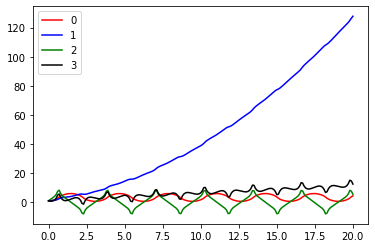

In [48]:
colors = ['r', 'b', 'g', 'k']
x_test = integrate.odeint(pendulum_on_cart_deriv, u0, t)
for i in range(r):
    plt.plot(t, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
plt.legend()

In [49]:
sol.u

[array([0.5693403 , 0.94076589, 0.95007627, 0.90688556])]

In [50]:
print(feature_names[1], sindy_opt.coef_[3, 1])
print(feature_names[2], sindy_opt.coef_[4, 2])
print(feature_names[123])
print(feature_names[124])

du[0] -3.305921304797901e-06
du[1] 2.75723140735175e-06
sin(u[0])*sin(u[0])*du[2]
sin(u[0])*sin(u[0])*du[3]


(199, 4)
(201, 4) (199, 189)


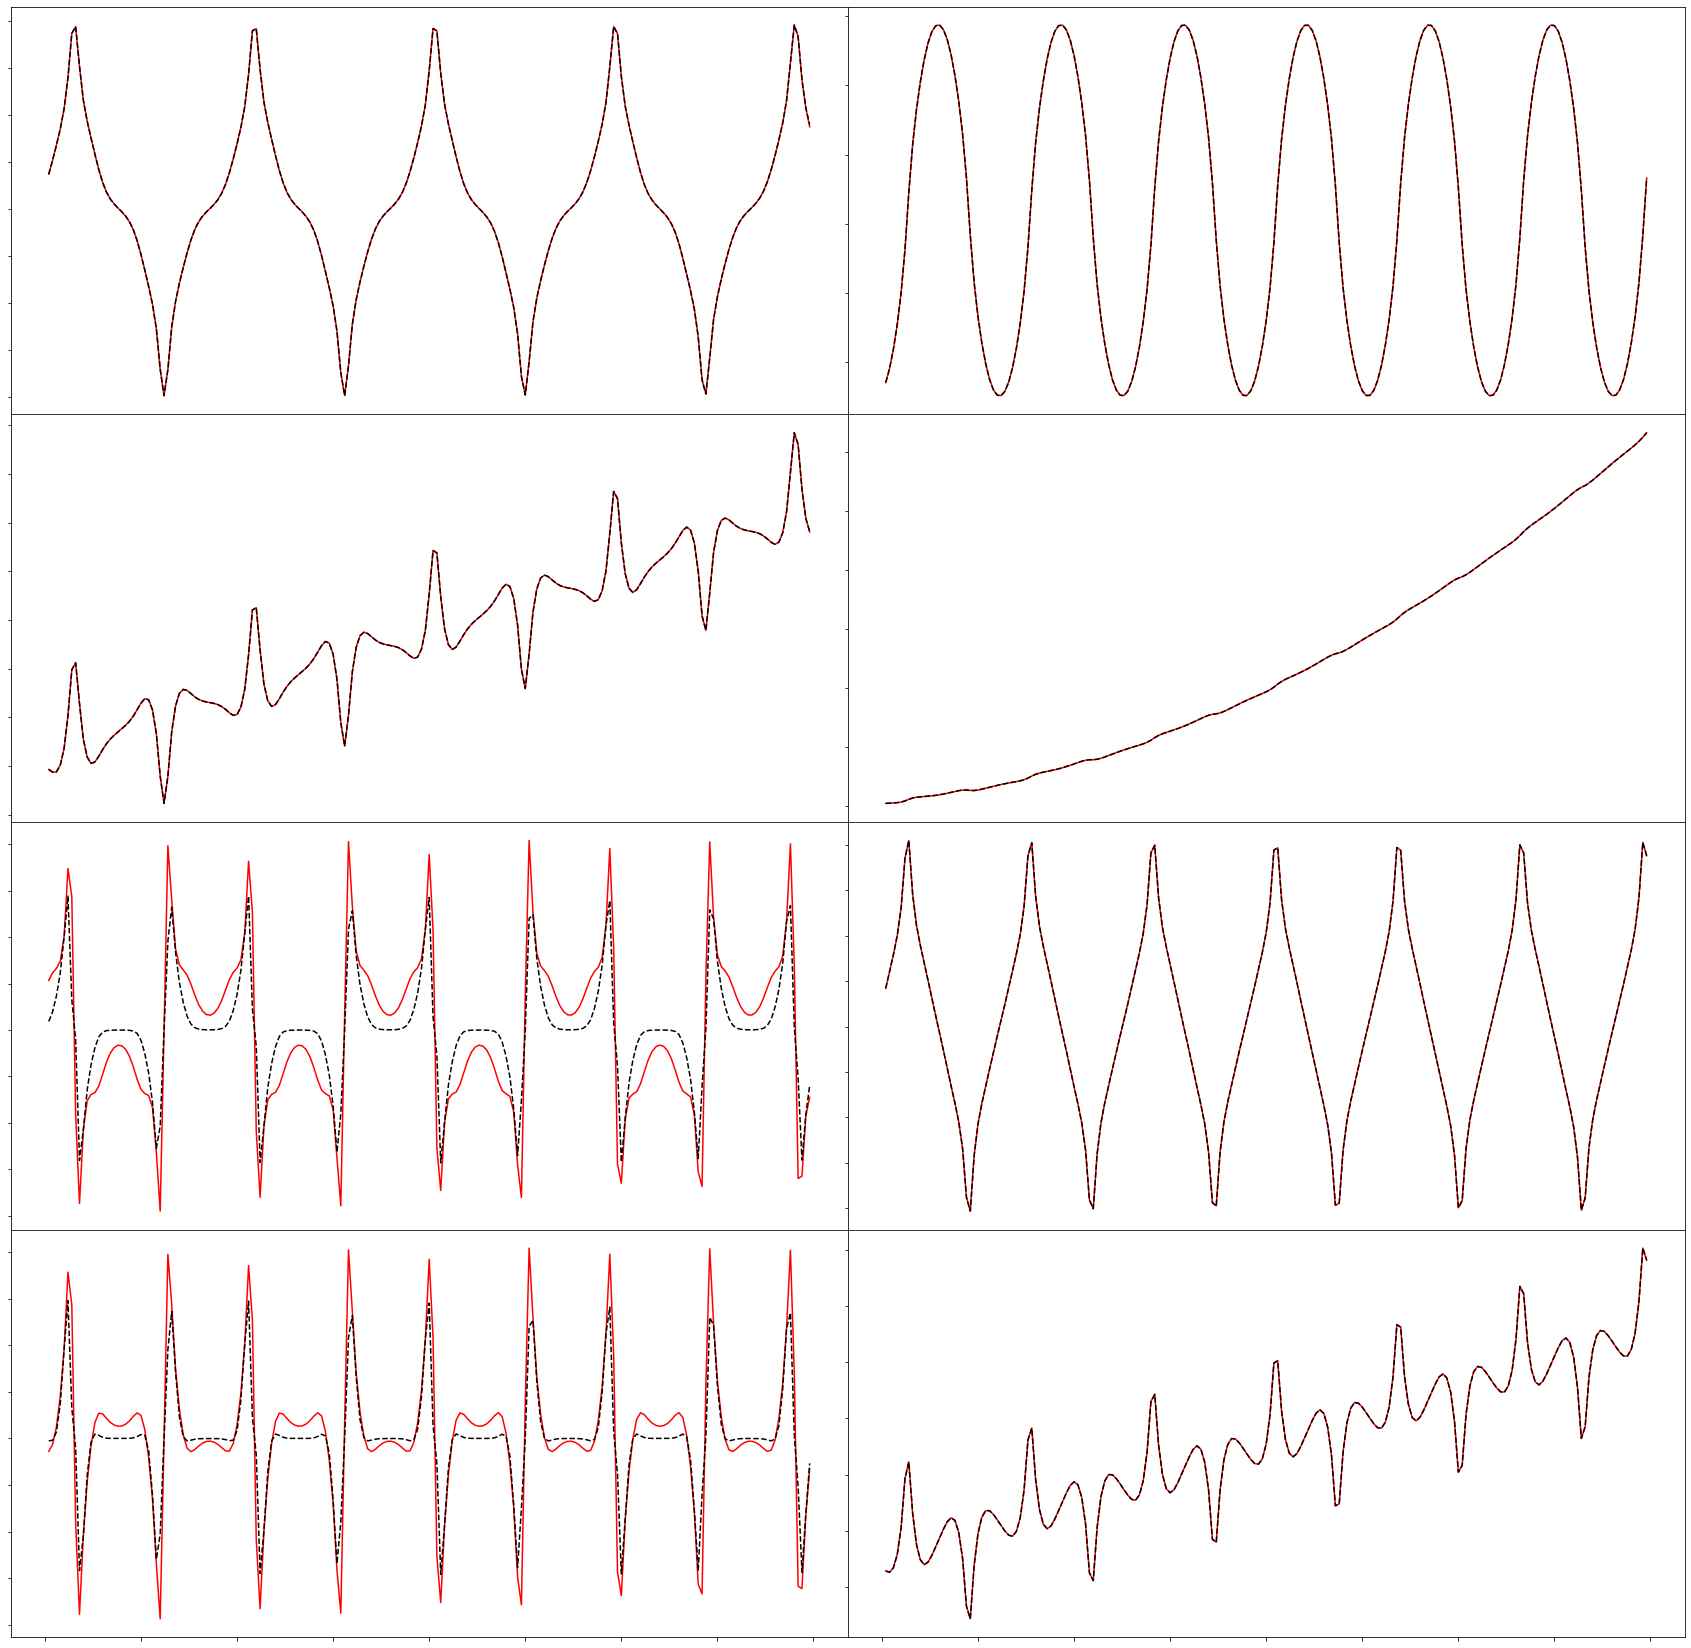

In [54]:
xdot_test = model.differentiate(x_train, t=t)[1:-1, :]
print(xdot_test.shape)
xdot_test_pred = sindy_opt.Theta @ sindy_opt.coef_
print(x_test.shape, xdot_test_pred.shape)
make_fits(r, t[1:-1], xdot_test, xdot_test_pred[:, [1, 2, 123, 124]], x_test[1:-1], x_test[1:-1], 'pendulum_on_cart')

0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]
58 cos(u[2])*du[1]
59 cos(u[2])*du[2]
60 cos(u[2])*du[3]
61 cos(u[3])*du[0]
62 cos(u[3])*du[1]
63 cos(u[3])*du

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in double_scalars
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


[nan, nan, nan, nan]
[nan, nan, nan, nan]
[0.5412454978744968, 0.29319272424361775, -0.008054940999884224, -0.015275660145127412]
[0.89946399435348, 0.4642689167664552, -100.14398766195836, 0.8337409489030608]
[-98.26074860904859, -9.952224836281419, -72.42417142028152, -37821.00877196682]
[6.369182700493717, 17.633183579713997, 1.3145213974775403, -666.0951714900466]
[-16.18439479078667, -18.821318144506233, 108.29260231987178, 694.2270146605879]
[0.5213527313991118, 0.27002202603663983, -0.08231067594277713, 0.7303213372573468]
[0.45710661745267744, 0.21398596496314276, -0.16424599630505565, 2.639287088658225]
[0.3645266617545603, 0.14095419137634038, -0.22162991890663997, 5.13969879647091]
[0.26704156701869153, 0.07179884677783632, -0.23491234668456062, 7.482228087404665]
[0.1835386136502828, 0.020944535332974634, -0.20879780316024155, 9.15556645291993]
[0.12202567497818761, -0.00837871011193958, -0.16256126170549434, 10.0549950394554]
[0.08142237720354295, -0.020737248517522122, -0

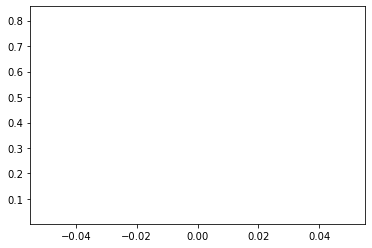

In [55]:
coef_indices = [1, 2, 123, 124]
r = 4
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string, temp_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_index)


# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 2)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
#plt.plot(t, integrate.odeint(pendulum_on_cart_deriv, u0, t), 'r')
plt.plot(sol.t, sol.u, 'k--')
print(sol)